In [1]:
!pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.1.2 requires requests<2.29,>=2.24.0, but you have requests 2.29.0 which is incompatible.
librosa 0.10.0.post2 requires soundfile>=0.12.1, but you have soundfile 0.11.0 which is incompatible.
kfp 1.8.20 requires google-api-python-client<2,>=1.7.8, but you have google-api-python-client 2.86.0 which is incompatible.
kfp 1.8.20 requires PyYAML<6,>=5.3, but you have pyyaml 6.0 which is incompatible.
gcsfs 2023.3.0 requires fsspec==2023.3.0, but you have fsspec 2023.4.0 which is incompatible.
beatrix-jupyterlab 2023.46.184821 requires jupyter-server~=1.16, but you have jupyter-server 2.5.0 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 10.0.1 which is incompa

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=100):
    print(f"Searching for {term}")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [3]:
urls = search_images('beer photos', max_images=5)
for url in urls:
    print(url)

Searching for beer photos
https://www.liquor.com/thmb/9LXE40rADbTk-dQzQpjF6asP3vs=/2121x1414/filters:fill(auto,1)/GettyImages-1286622678-b8d7494f440c428ebe6abb22a5e951f2.jpg
https://p2d7x8x2.stackpathcdn.com/wordpress/wp-content/uploads/2014/10/Craft-Beer.jpg
http://www.pixelstalk.net/wp-content/uploads/2016/07/HD-Beer-Images.jpg
https://www.liquorista.com/wp-content/uploads/2018/03/Ten-of-the-Finest-Lagers-in-the-US.jpeg
https://g.foolcdn.com/editorial/images/544679/flight-of-beer.jpg


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


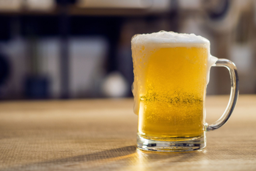

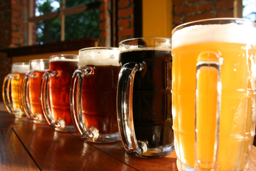

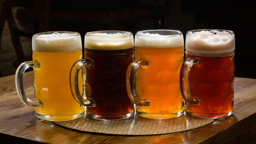

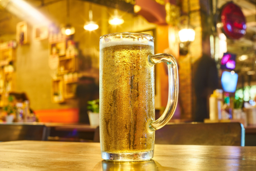

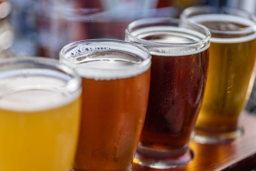

In [4]:
from fastdownload import download_url
from fastai.vision.all import *

for count, url in enumerate(urls):
    dest = f"beer_{count}"
    try:
        download_url(url, dest, show_progress=False)
        im = Image.open(dest)
        display(im.to_thumb(256, 256))
    except:
        print("Something went wrong")
    

In [5]:
from time import sleep

categories = 'beer', 'wine', 'vodka', 'whisky'
path = Path('alcohol_type')

for category in categories:
    dest = (path/category)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{category} photo'))
    
    sleep(10)
    
    resize_images(path/category, max_size=400, dest=path/category)


Searching for beer photo
Searching for wine photo
Searching for vodka photo


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Searching for whisky photo


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [6]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

12

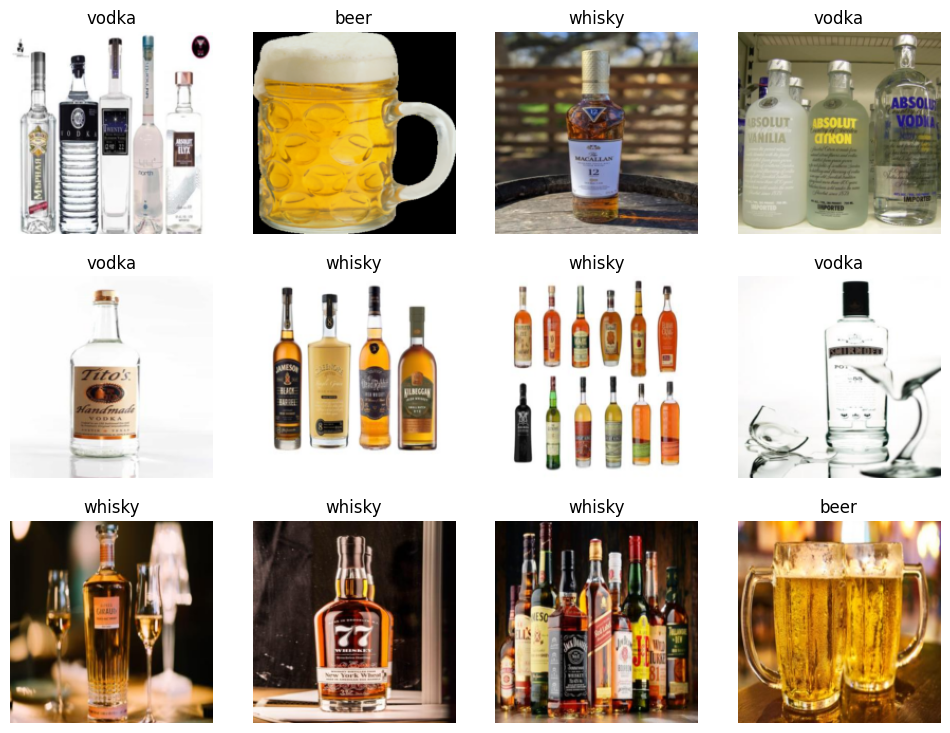

In [7]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=420),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=12)

In [8]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(20)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 58.3MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,2.012553,0.655065,0.246575,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.713711,0.502909,0.232877,00:02
1,0.590701,0.434847,0.219178,00:01
2,0.437696,0.410566,0.164384,00:02
3,0.340185,0.351143,0.123288,00:02
4,0.262166,0.343273,0.150685,00:02
5,0.205362,0.338305,0.136986,00:02
6,0.162546,0.334388,0.136986,00:02
7,0.129213,0.378040,0.136986,00:02
8,0.103910,0.372806,0.123288,00:03
9,0.085064,0.379948,0.123288,00:02


In [9]:
amount = 5
beers = [f'beer_{x}' for x in range(amount)]

This is a: beer


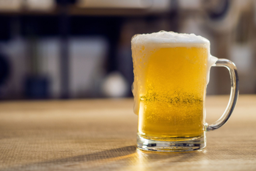

Probability it's a beer: 0.9999771118164062


This is a: beer


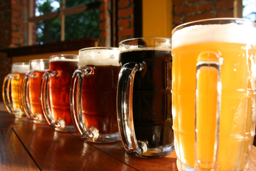

Probability it's a beer: 0.7579272389411926


This is a: beer


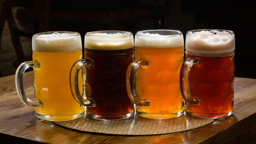

Probability it's a beer: 0.9999972581863403


This is a: beer


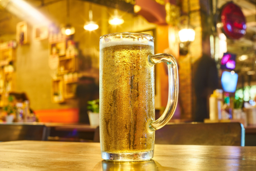

Probability it's a beer: 0.9882428050041199


This is a: beer


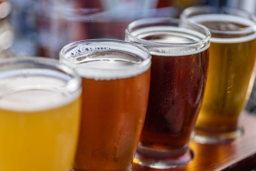

Probability it's a beer: 0.9971816539764404


In [10]:
for beer in beers:
    prediceted_category, _, probs = learn.predict(PILImage.create(beer))
    print(f'This is a: {prediceted_category}')
    im = Image.open(beer)
    display(im.to_thumb(256, 256))
    print(f'Probability it\'s a beer: {probs[0]}')